# Network Subgroups
Finding subgroups in your network

## Import library and define auxiliary functions

In [50]:
import sys
import os

import networkx as nx
from networkx.algorithms import community
import matplotlib.pyplot as plt
import collections

import community as louvain #from python-louvain

In [51]:
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [52]:
from src.graphutil.visualization import draw_graph_and_color_groups



## Connected Components

Name: 
Type: DiGraph
Number of nodes: 8
Number of edges: 11
Average in degree:   1.3750
Average out degree:   1.3750


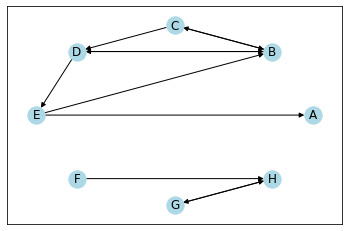

In [53]:
G = nx.DiGraph()
G.add_nodes_from(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'])
G.add_edges_from([('B', 'C'), ('B', 'D'),
                  ('C', 'B'), ('C', 'D'),
                  ('D', 'E'), ('D', 'B'),
                  ('E', 'A'), ('E', 'B'),
                  ('F', 'H'),
                  ('G', 'H'),
                  ('H', 'G'),
                 ])
print(nx.info(G))
nx.draw_networkx(G, pos= nx.drawing.layout.circular_layout(G), node_color="lightblue")

### Strongly connected components
Connectivity 

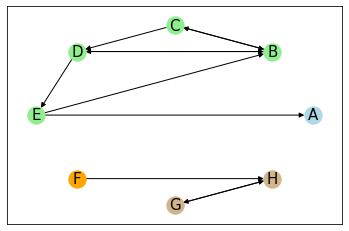

In [54]:
strongly_connected_components = nx.strongly_connected_components(G)
draw_graph_and_color_groups(G, strongly_connected_components)

### Weakly connected components
A directed Graph must be transformed to an undirected in order to calculate the weakly connected components in networkX

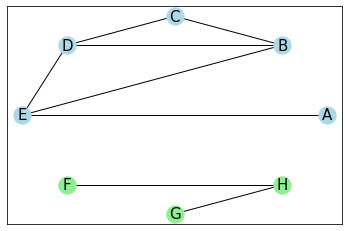

In [55]:
G_undirected = G.to_undirected()
weakly_connected_components = nx.connected_components(G_undirected)
draw_graph_and_color_groups(G_undirected, weakly_connected_components)

### Giant Component
Find Largest Strongly Connected Component and then create a subgraph (filtering all the other nodes and edges pointing to nodes outside of the giant component)

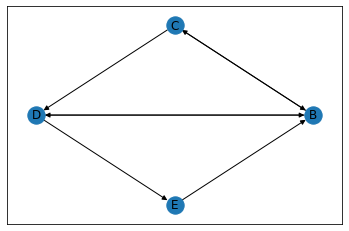

In [56]:
largest_scc = max(nx.strongly_connected_components(G), key=len)
giant_component = nx.subgraph(G, largest_scc)
nx.draw_networkx(giant_component, pos= nx.drawing.layout.circular_layout(giant_component))

## k-Core
Calculating k-core is also efficient on very large graphs (especially compared to other clustering algorithms). It takes O(m) where m is the number of edges.

In [57]:
G = nx.Graph()
G.add_nodes_from(['A', 'B', 'C', 'D', 'E', 'F', 'G'])
G.add_edges_from([('A', 'B'), ('A', 'C'), ('A', 'D'),
                 ('B', 'C'), ('B', 'D'),
                 ('C', 'D'),
                 ('E', 'D'), ('E', 'F'), ('E', 'G'),
                 ('F', 'G')])

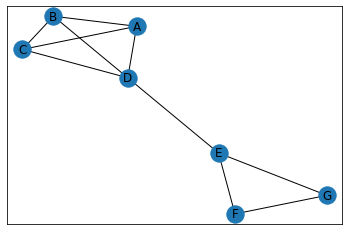

In [58]:
nx.draw_networkx(G)

In [59]:
nx.core_number(G)

{'A': 3, 'B': 3, 'C': 3, 'D': 3, 'E': 2, 'F': 2, 'G': 2}

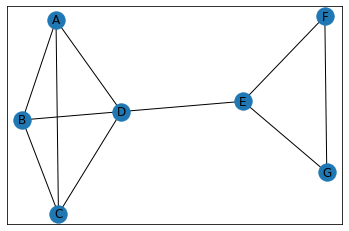

In [60]:
core_subgraph = nx.k_core(G, 2)
nx.draw_networkx(core_subgraph)

## Communities
Community detection algorithms must be imported additionally using:

```from networkx.algorithms import community```

### Girvan Newman Clustering (Edge Betweenness Clustering)

In [61]:
G = nx.Graph()
G.add_nodes_from(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'])
G.add_edges_from([('A', 'B'), 
                  ('B', 'C'), ('B', 'D'), ('B', 'E'), 
                  ('D', 'E'), ('D', 'F'), ('D', 'G'), 
                  ('F', 'G'), ('F', 'H')
                 ])

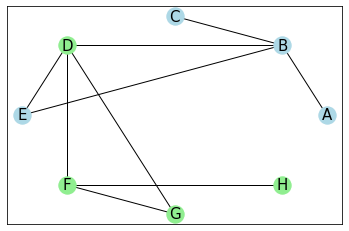

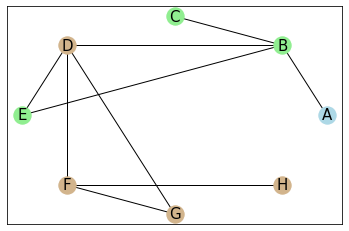

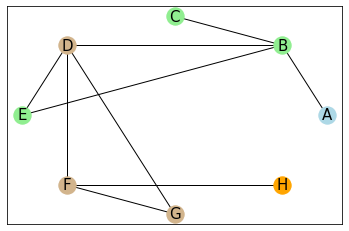

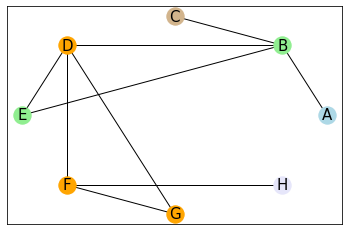

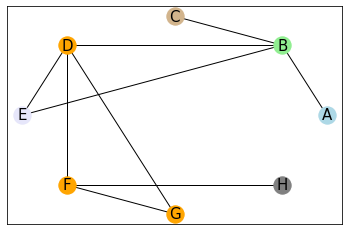

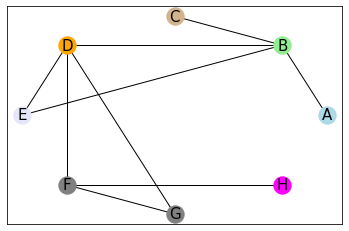

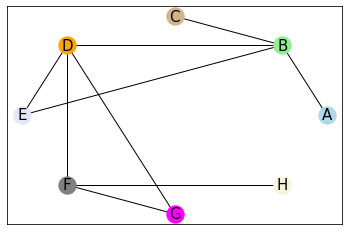

In [62]:
# Edge-Betweenness-Clustering
edge_betw_communities = list(community.girvan_newman(G))
num_steps = len(edge_betw_communities)

for i, step in enumerate(edge_betw_communities):
    plt.figure(i)
    draw_graph_and_color_groups(G, step)

## Label propagation

Show initial graph coloring

Initial state
{'B': 0, 'D': 1, 'F': 0, 'E': 2, 'G': 2, 'A': 1, 'C': 1, 'H': 1}
defaultdict(<class 'set'>, {0: {'F', 'B'}, 1: {'H', 'D', 'A', 'C'}, 2: {'G', 'E'}})


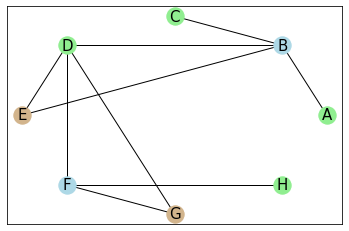

In [63]:
colors = nx.greedy_color(G)
inv_map = collections.defaultdict(set)
for node, color in colors.items():
    inv_map[color].add(node)
print("Initial state")
print(colors)
print(inv_map)
draw_graph_and_color_groups(G, inv_map.values())

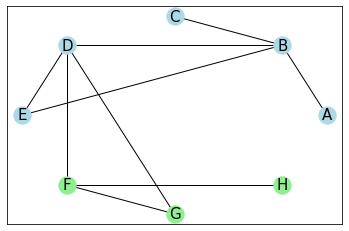

In [64]:
# label Propagation
label_communities = community.label_propagation_communities(G)
draw_graph_and_color_groups(G, label_communities)

### Modularity based clustering
#### NetworkX Greedy Modularity

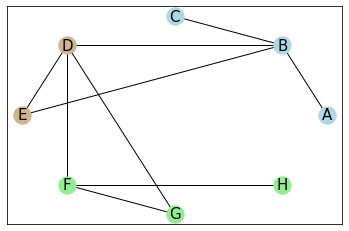

In [65]:
# Modularity
mod_communities = community.greedy_modularity_communities(G)
draw_graph_and_color_groups(G, mod_communities)


#### Louvain

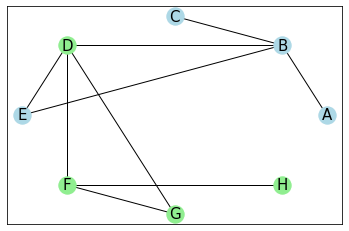

In [66]:
import matplotlib.cm as cm
louv_communities = louvain.best_partition(G)

partitions = dict()
for k,v in louv_communities.items():
    partitions.setdefault(v, []).append(k)

draw_graph_and_color_groups(G, partitions.values())


### Comparing performance of different community detection algorithms

In [67]:
num_nodes = 10000
probability = 0.001
performance_graph = nx.erdos_renyi_graph(num_nodes, probability, seed=42)
print(nx.info(performance_graph))

Name: 
Type: Graph
Number of nodes: 10000
Number of edges: 49722
Average degree:   9.9444


In [68]:
%%time
subgraph = nx.k_core(performance_graph, 2)
print(subgraph.number_of_nodes())
print("Finished 2-core")

9999
Finished 2-core
CPU times: user 313 ms, sys: 10.1 ms, total: 323 ms
Wall time: 322 ms


In [69]:
%%time
# label Propagation
clusters = list(community.label_propagation_communities(performance_graph))
print("Finished Label Propagation")

Finished Label Propagation
CPU times: user 376 ms, sys: 4.34 ms, total: 380 ms
Wall time: 378 ms


In [70]:
%%time
clusters = list(community.greedy_modularity_communities(performance_graph))
print("Finished Modularity Clustering")

Finished Modularity Clustering
CPU times: user 37.6 s, sys: 0 ns, total: 37.6 s
Wall time: 37.6 s


In [71]:
%%time
clusters = list(louvain.best_partition(performance_graph))
print("Finished Louvain Clustering")

Finished Loivain Clustering
CPU times: user 8.64 s, sys: 7.47 ms, total: 8.65 s
Wall time: 8.64 s
